# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_trajectory_predictunseen"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix


cpu


'Jun14-2115'

In [4]:
state_key = 'time'
batch_key = 'batch'
state_type = 'trajectory'
distribution = 'normal'
batch_distribution = 'normal'
leiden_key = 'leiden_no_noise'
batch_dispersion = [2.0,2.0,2.0]
batch_level = [10,10]

In [5]:
import numpy as np
from concord.utils.simulation import (
    Simulation,
    SimConfig, TrajectoryConfig,   # ← note the different state config
    BatchConfig,
)

# ── batch side: identical to before ─────────────────────────────────────
rng = np.random.default_rng(42)
n_batches = 5
batch_level = 10 * rng.normal(1, 0.5, size=n_batches)   # centred at 10, σ≈5

batch_cfg = BatchConfig(
    n_batches     = n_batches,
    effect_type   = "batch_specific_features",
    distribution  = "normal",
    level         = batch_level.tolist(),      # ndarray → list
    dispersion    = 2.0,                      # same σ for every batch
    feature_frac  = 0.10,
    cell_proportion = [.2,.5,.3,.1,.4],  # batch-specific cell proportions
)

# ── global options (unchanged) ──────────────────────────────────────────
sim_cfg = SimConfig(
    n_cells = 1000,
    n_genes = 100,
    seed    = 42,
    non_neg = True,
    to_int  = True,
)

# ── state side: trajectory instead of clusters ─────────────────────────
state_cfg = TrajectoryConfig(
    # ► everything below corresponds 1-to-1 to the old call ◀︎
    distribution              = "normal",
    level                     = 10,           # state_level
    min_level                 = 0,
    dispersion                = 2.0,          # state_dispersion
    program_num               = 5,            # trajectory_program_num
    program_structure         = "linear_bidirectional",
    program_on_time_fraction  = 0.10,
    cell_block_size_ratio     = 0.60,         # trajectory_cell_block_size_ratio
    loop_to                   = None,         # trajectory_loop_to
)

# ── run ─────────────────────────────────────────────────────────────────
sim = Simulation(sim_cfg, state_cfg, batch_cfg)
adata, adata_state = sim.simulate_data()
adata.layers["counts"] = adata.X.copy()


In [6]:
adata.obs['train_use'] = True
adata.obs['train_use'][adata.obs[batch_key] == 'batch_3'] = False

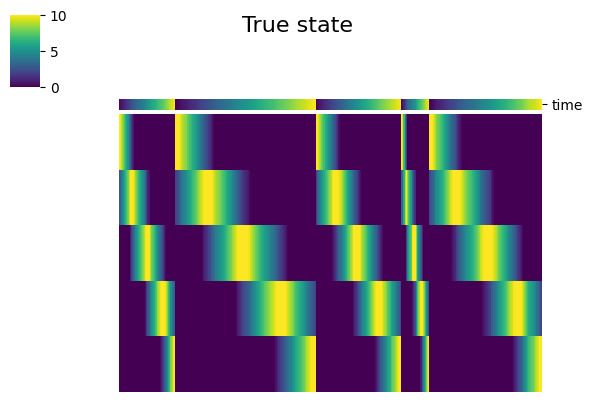

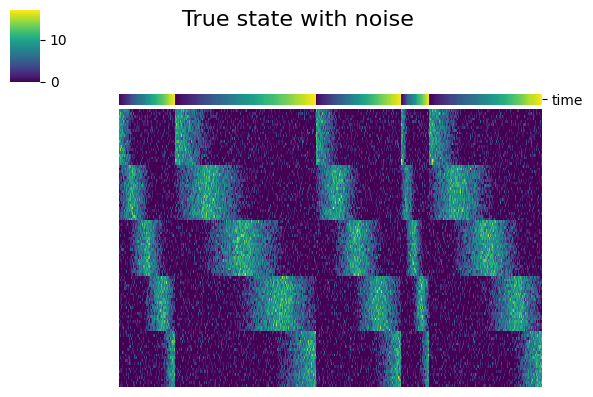

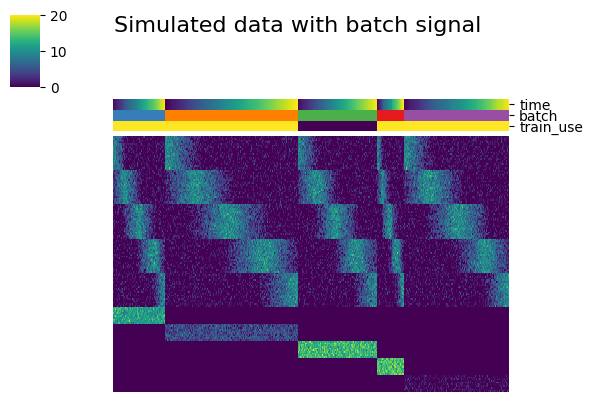

In [7]:
ccd.pl.heatmap_with_annotations(adata_state, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata_state, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key, 'train_use'], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)

### Concord

In [8]:
adata_train = adata[adata.obs['train_use']].copy()
adata_pred = adata[~adata.obs['train_use']].copy()

In [13]:
cur_ccd = ccd.Concord(adata=adata_train, 
                      input_feature=None, 
                      domain_key=batch_key, # key in adata.obs that contains the domain labels
                      seed=seed, # random seed
                      verbose=True, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir / 'model/' # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'

cur_ccd.encode_adata(output_key=output_key)

# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

Concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
Concord - INFO - Setting sampler_knn to 120 to be 1/10 the number of cells in the dataset. You can change this value by setting sampler_knn in the configuration.
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - INFO - Proceeding with all 150 features in the dataset.
Concord - INFO - Column 'batch' is already of type: category
Concord - INFO - Unused levels dropped for column 'batch'.
Concord - INFO - Encoder input dim: 150
Concord - INFO - Model loaded to device: cpu
Concord - INFO - Total number of parameters: 129868
Concord - INFO - PCA embedding not found in adata.obsm. Running PCA...


Concord - INFO - PCA completed.


FAISS not found. Using sklearn for k-NN computation.


Concord - INFO - Starting epoch 1/10
Concord - INFO - Processing chunk 1/1 for epoch 1
Concord - INFO - Number of samples in train_dataloader: 1200


Epoch 0 Training: 100%|██████████| 17/17 [00:00<00:00, 146.58it/s, loss=3.8] 

Concord - INFO - Epoch   0 | Train Loss: 4.00, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.00, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 2/10
Concord - INFO - Processing chunk 1/1 for epoch 2
Concord - INFO - Number of samples in train_dataloader: 1200



Epoch 1 Training: 100%|██████████| 17/17 [00:00<00:00, 182.89it/s, loss=3.74]

Concord - INFO - Epoch   1 | Train Loss: 3.77, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.77, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 3/10
Concord - INFO - Processing chunk 1/1 for epoch 3
Concord - INFO - Number of samples in train_dataloader: 1200



Epoch 2 Training: 100%|██████████| 17/17 [00:00<00:00, 219.57it/s, loss=3.7]

Concord - INFO - Epoch   2 | Train Loss: 3.69, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.69, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 4/10
Concord - INFO - Processing chunk 1/1 for epoch 4
Concord - INFO - Number of samples in train_dataloader: 1200



Epoch 3 Training: 100%|██████████| 17/17 [00:00<00:00, 237.66it/s, loss=3.67]

Concord - INFO - Epoch   3 | Train Loss: 3.62, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.62, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 5/10
Concord - INFO - Processing chunk 1/1 for epoch 5
Concord - INFO - Number of samples in train_dataloader: 1200



Epoch 4 Training: 100%|██████████| 17/17 [00:00<00:00, 285.48it/s, loss=3.59]

Concord - INFO - Epoch   4 | Train Loss: 3.58, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.58, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 6/10
Concord - INFO - Processing chunk 1/1 for epoch 6
Concord - INFO - Number of samples in train_dataloader: 1200



Epoch 5 Training: 100%|██████████| 17/17 [00:00<00:00, 238.08it/s, loss=3.58]

Concord - INFO - Epoch   5 | Train Loss: 3.56, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.56, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 7/10
Concord - INFO - Processing chunk 1/1 for epoch 7
Concord - INFO - Number of samples in train_dataloader: 1200



Epoch 6 Training: 100%|██████████| 17/17 [00:00<00:00, 233.94it/s, loss=3.61]

Concord - INFO - Epoch   6 | Train Loss: 3.55, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.55, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 8/10
Concord - INFO - Processing chunk 1/1 for epoch 8
Concord - INFO - Number of samples in train_dataloader: 1200



Epoch 7 Training: 100%|██████████| 17/17 [00:00<00:00, 241.15it/s, loss=3.51]

Concord - INFO - Epoch   7 | Train Loss: 3.53, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.53, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 9/10
Concord - INFO - Processing chunk 1/1 for epoch 9
Concord - INFO - Number of samples in train_dataloader: 1200



Epoch 8 Training: 100%|██████████| 17/17 [00:00<00:00, 244.00it/s, loss=3.54]

Concord - INFO - Epoch   8 | Train Loss: 3.54, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.54, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 10/10


Concord - INFO - Processing chunk 1/1 for epoch 10
Concord - INFO - Number of samples in train_dataloader: 1200


Epoch 9 Training: 100%|██████████| 17/17 [00:00<00:00, 298.61it/s, loss=3.48]

Concord - INFO - Epoch   9 | Train Loss: 3.53, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.53, IMPORTANCE: 0.00


Concord - INFO - Model saved to ../save/dev_simulation_trajectory_predictunseen-Jun14/model/final_model_Jun14-2116.pt
Concord - INFO - Final model saved at: ../save/dev_simulation_trajectory_predictunseen-Jun14/model/final_model_Jun14-2116.pt; Configuration saved at: ../save/dev_simulation_trajectory_predictunseen-Jun14/model/config_Jun14-2116.json.
Concord - INFO - Predicting for chunk 1/1


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Concord - INFO - UMAP embedding stored in adata.obsm['Concord_UMAP_2D']


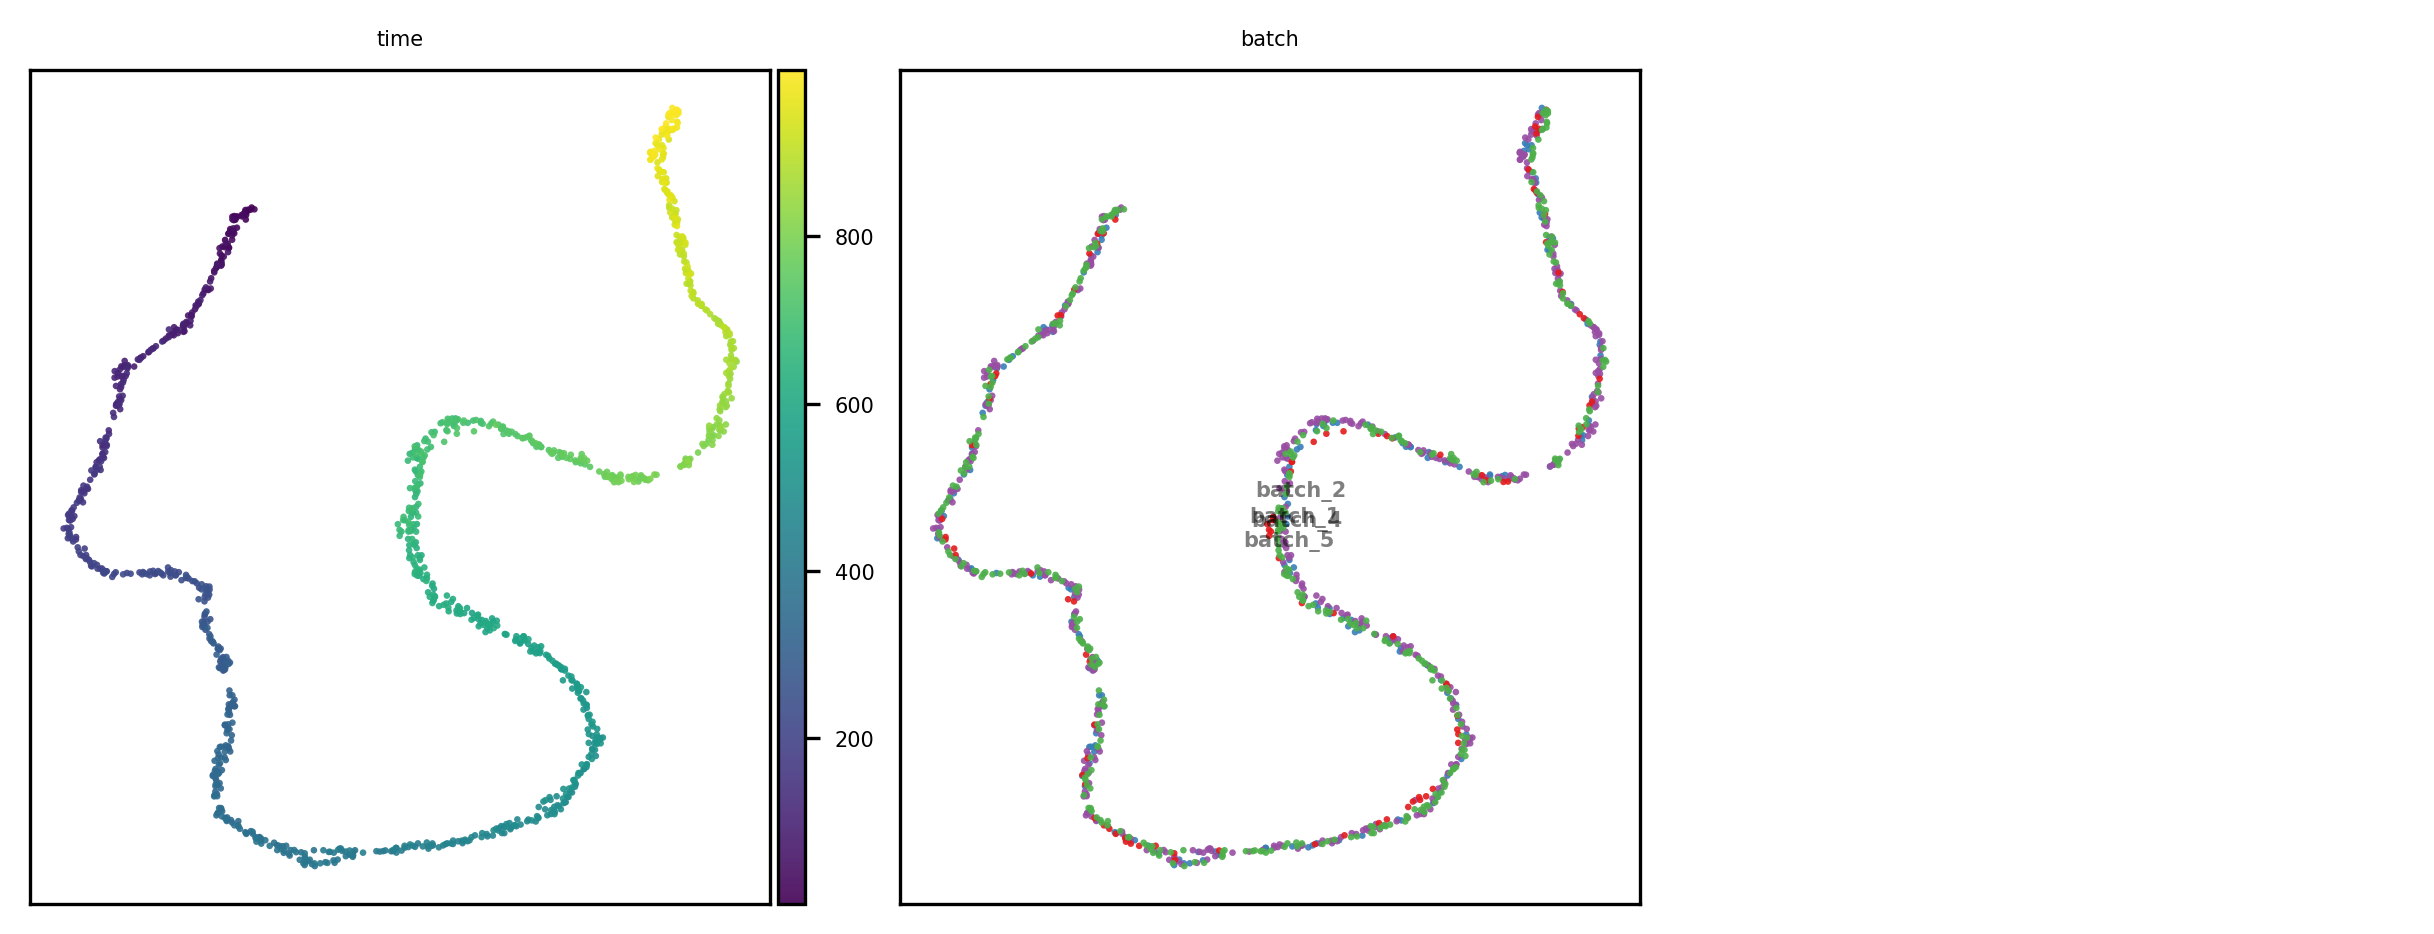

In [14]:
ccd.ul.run_umap(adata_train, source_key='Concord', result_key='Concord_UMAP_2D', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)

show_cols = [state_key, batch_key]
show_basis = 'Concord_UMAP_2D'   
ccd.pl.plot_embedding(
    adata_train, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    #pal = {'cluster':'Set1', 'batch':'Set2', 'leiden':'tab20'},
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)


In [15]:
adata_pred.obs['batch'] = adata_pred.obs['batch'].astype('category')
concord_model = ccd.Concord.load(model_dir=save_dir / 'model/',)

# 2. Predict on a new AnnData object with a simple, high-level method
# This method handles all the internal setup automatically.
results = concord_model.predict_adata(
    adata_pred,
    output_key=output_key,  # Key in adata.obsm to store the latent representation
    return_latent=True,
    return_class_prob=True
)


Concord - INFO - Loading configuration from: ../save/dev_simulation_trajectory_predictunseen-Jun14/model/config_Jun14-2116.json
Concord - INFO - Loading model weights from: ../save/dev_simulation_trajectory_predictunseen-Jun14/model/final_model_Jun14-2116.pt
Concord - INFO - Encoder input dim: 150
Concord - INFO - Model loaded to device: cpu
Concord - INFO - Total number of parameters: 129868
Concord - INFO - Loading pre-trained model from ../save/dev_simulation_trajectory_predictunseen-Jun14/model/final_model_Jun14-2116.pt


Concord - INFO - Pre-trained Concord model loaded successfully.
Concord - INFO - Generating predictions for the new data...
Concord - INFO - Predicting for chunk 1/1
Concord - INFO - Predictions completed and stored in the new AnnData object in following keys:
Concord - INFO -  - Concord in obsm for embeddings
Concord - INFO -  - Concord_encoder_2 in obsm for latent variables of encoder_2
Concord - INFO -  - Concord_encoder_6 in obsm for latent variables of encoder_6


In [16]:
adata_merge = adata_train.concatenate(adata_pred, batch_key='train_test', index_unique=None)

Concord - INFO - UMAP embedding stored in adata.obsm['Concord_UMAP_2D']


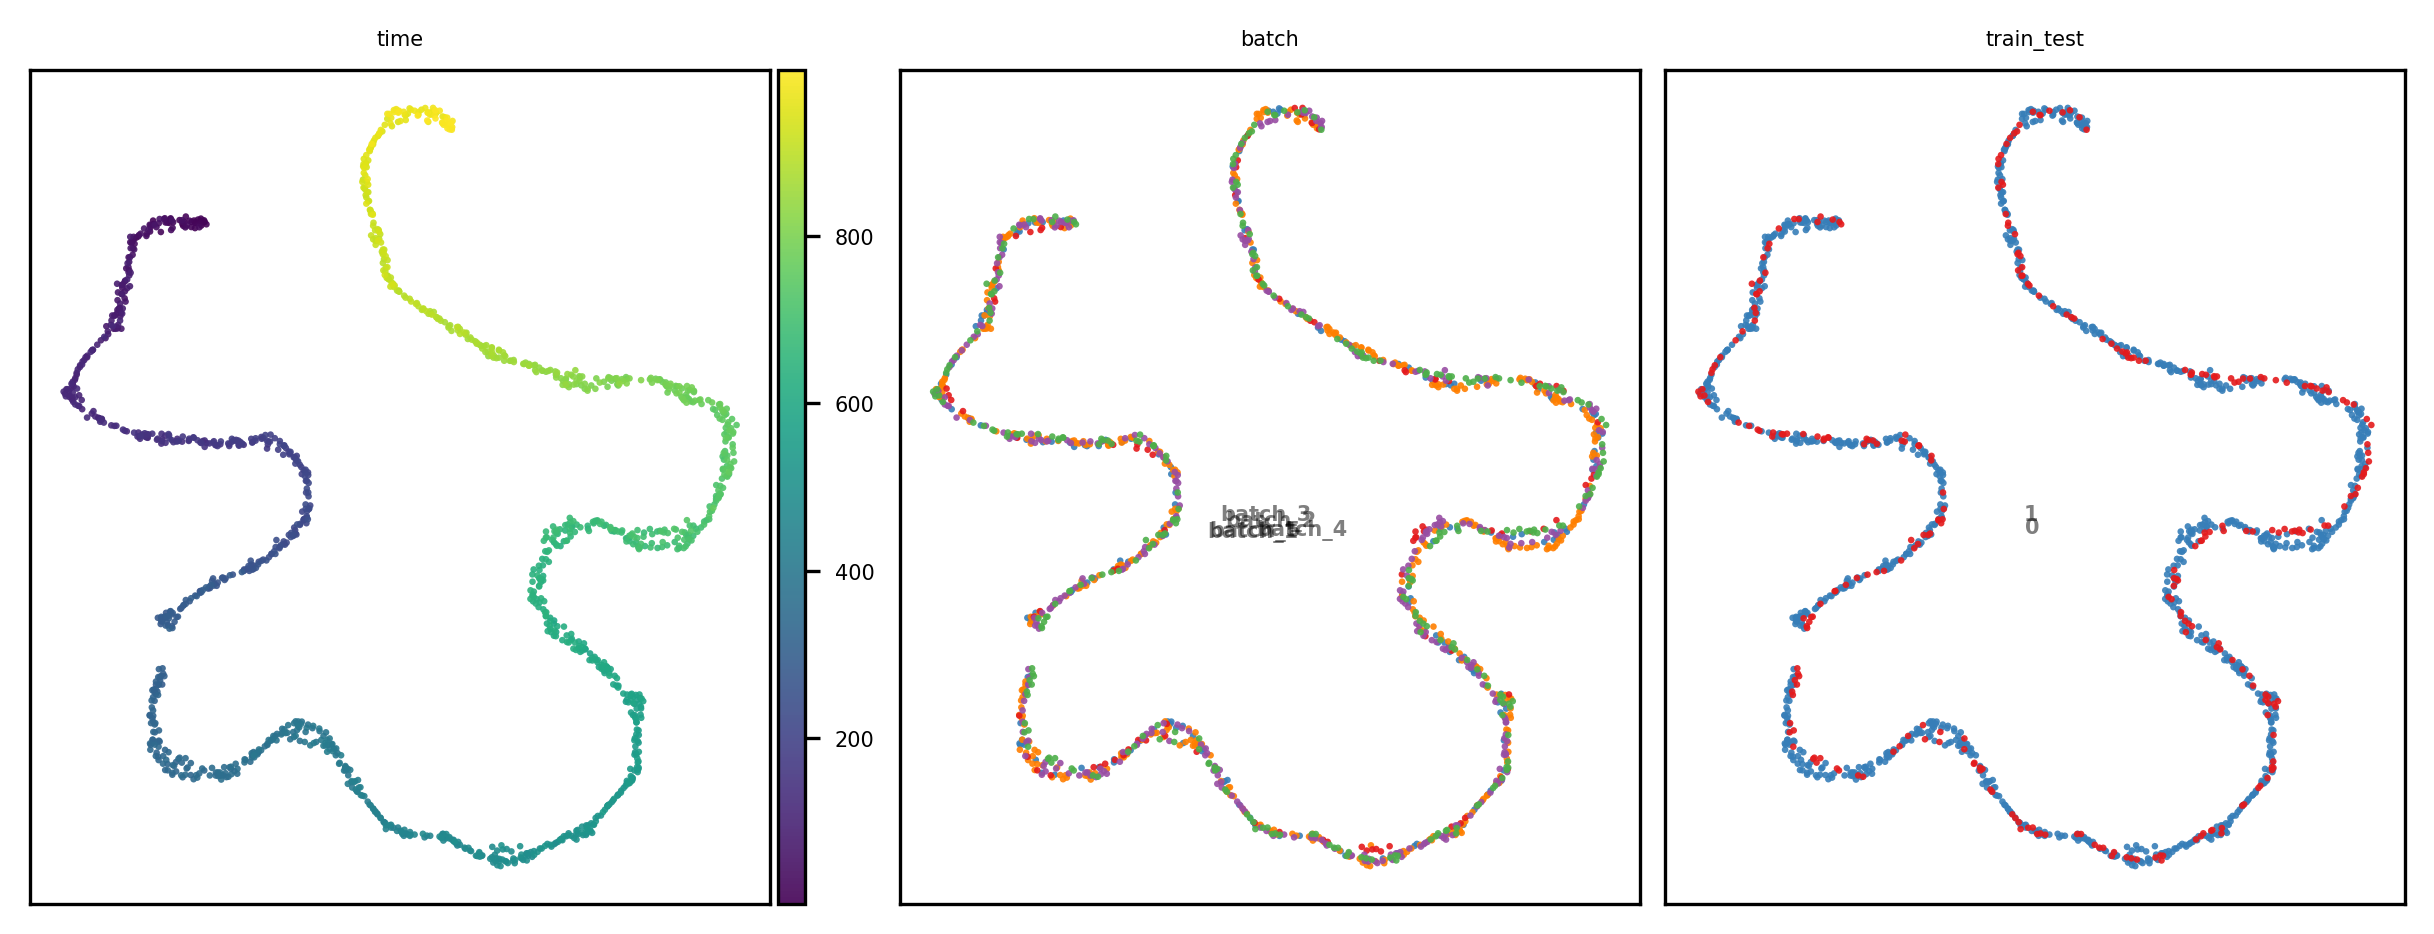

In [17]:
ccd.ul.run_umap(adata_merge, source_key='Concord', result_key='Concord_UMAP_2D', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)

show_cols = [state_key, batch_key, 'train_test']
show_basis = 'Concord_UMAP_2D'   
ccd.pl.plot_embedding(
    adata_merge, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    #pal = {'cluster':'Set1', 'batch':'Set2', 'leiden':'tab20'},
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)
